### DATA558 HW2
Emily Yamauchi

In [188]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Objective function:

$$
\begin{align}
F(\beta)=\frac{1}{n}\sum_{i=1}^n \log(1+\exp(-y_ix_i^\top \beta)) + \lambda||\beta||_2^2
\end{align}
$$

Find 

$$
 F(\beta^*)=\min_{\beta \in \mathbb{R}^d}F(\beta)
$$

In [4]:
def obj_function(X, y, beta, lamb):
    
    n = len(X)
    f1 = np.sum(np.log(1+np.exp(-y*np.dot(beta, X.T)))) * (1/n)
    f2 = np.linalg.norm(beta) ** 2*lamb
    
    return f1 + f2

1. Assume that $d=1$ and $n=1$. The sample is then of size 1 and boils down to just $(x, y)$. The function $F$ writes simply as

$$
F(\beta) = log(1+\exp(-yx\beta)) + \lambda\beta^2
$$

Compute and write down the gradient $\nabla F$ of $F$.

$$\begin{align}
F(\beta) &= log(1+\exp(-yx\beta)) + \lambda\beta^2 \\
\frac{d}{d\beta}F(\beta)&=\frac{1}{1+ \exp(-yx\beta)}\times \exp(-yx\beta) \times (-yx) + 2\lambda\beta\\
&=-yx\frac{\exp(-yx\beta)}{1+\exp(-yx\beta)} + 2\lambda\beta\\
\end{align}
$$

In [5]:
def compgrad_1(X, y, beta, lamb):
    
    num = np.exp(-y*X*beta)
    denom = 1+np.exp(-y*X*beta)
    
    #return -y*X*(np.exp(-y*x*beta)/1+np.exp(-y*x*beta))+2*lamb*beta
    
    return (-y*X*num/denom) + (2*lamb*beta)

2. Assume now that $d>1$ and $n>1$. Using the previous result and the linearity of differentiation, compute and write down the gradient $\nabla F(\beta)$ of $F$.

$$\begin{align}
F(\beta)&=\frac{1}{n}\sum_i^n\log(1+\exp(-y_ix_i^\top \beta)) + \lambda||\beta||_2^2 \\
\nabla F(\beta)&=\frac{1}{n}\sum_i^n\nabla\underbrace{ \log(1+\exp(-y_ix_i^\top \beta))}_1 + \underbrace{\nabla \lambda||\beta||_2^2}_2 \\
\end{align}
$$
1.
$$
\begin{align}
\scriptsize{\frac{d}{du}\log(u(x))=\frac{1}{\log(u)}\times u'(x)} \\
\nabla\log(1+\exp(-y_ix_i^\top \beta))&=\frac{1}{1+\exp(-y_ix_i^\top \beta)}\times \exp(-y_ix_i^\top \beta) \times -y_ix_i \\
&=-y_ix_i\times \frac{\exp(-y_ix_i^\top \beta)}{1+\exp(-y_ix_i^\top \beta)}
\end{align}$$
2.
$$
\begin{align}
\nabla \lambda||\beta||_2^2&=\lambda \beta^\top \beta\\
&=2\lambda\beta
\end{align}
$$
Bringing both components together
$$
\begin{align}
\nabla F(\beta)=\frac{1}{n}\sum_i^n-y_ix_i\frac{\exp(-y_ix_i^\top \beta)}{1+\exp(-y_ix_i^\top \beta)}+2\lambda\beta
\end{align}
$$

3. Consider the `smarket` dataset from *Introduction to Statistical Learning*. Download the data: 
    
    This dataset contains trading information for the S&P 500 over 1250 days from 2001 to 2005. For each date we have the percent return from the previous 5 days (the `Lag` features), the volume of shares traded (in billions), the percent return on the date itself (`Today`), and whether the market moved up or down (`Direction`). We will apply our gradient descent and fast gradient descent algorithms to fit a logistic regression model for the binary outcome `Direction` based on the features `Lag1`, `Lag2`, and `Volume`.

In [6]:
file = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv(file, sep=',', header=0, index_col=0)
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


4. Construct the matrix of the features and response. Transform the response to a vector with entries in $\{+1,-1\}$, corresponding to whether `Direction` is 'Up' or 'Down', respectively. Split the data into train and test sets (80/20 split) and standardize the features.

In [7]:
smarket['response'] = [1 if x == 'Up' else -1 for x in smarket['Direction']]

X = np.array(smarket.iloc[:,np.r_[1:3,6]])
y = np.array(smarket.response)

print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (1250, 3)
y.shape:  (1250,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1000, 3)
X_test.shape:  (250, 3)
y_train.shape:  (1000,)
y_test.shape:  (250,)


In [9]:
Xscale = preprocessing.StandardScaler().fit(X_train)
Xs = Xscale.transform(X_train)

print('Xs.shape: ', Xs.shape)

Xs.shape:  (1000, 3)


5. Write a function *computegrad* that computes and returns $\nabla F(\beta)$ for any $\beta$.

In [100]:
def computegrad(X, y, beta, lamb):
    """
    Compute the gradient of the objective function for n>1 and d>1
    
    Params:
    X : nxd matrx
    y : nx1 matrix
    beta : 1xd matrix
    lamb: float
    """
    n = X.shape[0]

    exp = np.exp(np.multiply(-y, np.dot(X,beta)))
    Q = np.diag(exp/(1+exp))
    f1 = (X.T.dot(Q.dot(y))) * (-1/n) 
    f2 = 2*lamb*beta
    
    return f1 + f2

In [102]:
def f(beta):
    return obj_function(Xs, y_train, beta, lamb)

def f_grad(beta):
    return computegrad(Xs, y_train, beta, lamb)

f_grad(beta_init)

array([1.17399575, 1.16786162, 1.14485299])

6. Write a function *backtracking* that implements the backtracking rule.

In [79]:
def backtracking(eta_init, decay_rate, prop_constant, f, f_grad, beta, p):
    
    eta = eta_init
    
    def sufficient_decrease(eta):
        lhs = f(beta + eta * p) - f(beta)
        rhs = prop_constant * eta * np.dot(f_grad(beta), p)
        #print('lhs: ', lhs, ' rhs: ', rhs)
        return lhs <= rhs
    
    while not sufficient_decrease(eta):
        eta *= decay_rate
        
    return eta

7. Write a function *graddescent* that implements the gradient descent algorithm with the backpacking rule to tune the step-size. The function *graddescent* calls the *computegrad* and *backtracking* as subroutines. The function takes as input the initial point, the initial step-size value, and the target accuracy $\epsilon$. The stopping criterion is $||\nabla F||\leq \epsilon$.

In [80]:
def graddescent(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb):
    
    beta_t = beta_init
    betas = [beta_t]
    eta = eta_init
    
    def f(beta):
        
        return obj_function(Xs, y_train, beta, lamb)
    
    def f_grad(beta):
        
        return computegrad(Xs, y_train, beta, lamb)
    
    f_norm = np.linalg.norm(f_grad(beta_t))
    
    while not f_norm <= target_accuracy:
        
        #p = -f_grad(beta_t)
        eta = backtracking(eta_init, decay_rate, prop_constant, f, f_grad, beta_t, -f_grad(beta_t))
        beta_t = beta_t + eta * -f_grad(beta_t)
        #print('eta: ', eta)
        betas.append(beta_t)
        #print(beta_t)
        f_norm = np.linalg.norm(f_grad(beta_t))
        #print('fnorm: ',f_norm)
    
    return betas    

In [103]:
eta_init = 1
decay_rate = 0.8
beta_init = np.ones(3)
prop_constant = 0.3
#1/(np.max(np.linalg.eigh((1/len(Xs))*np.dot(Xs.T,Xs))[0])+lamb)
lamb = 0.5
target_accuracy = 0.05

graddescent(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)

[array([1., 1., 1.]),
 array([-0.17399575, -0.16786162, -0.14485299]),
 array([0.02471644, 0.02185096, 0.05922615]),
 array([-0.02498608, -0.02316685,  0.00862588])]

In [82]:
L = 1/(np.max(np.linalg.eigh((1/len(Xs))*np.dot(Xs.T,Xs))[0])+lamb)

In [104]:
graddescent(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)

[array([1., 1., 1.]),
 array([-0.17399575, -0.16786162, -0.14485299]),
 array([0.02471644, 0.02185096, 0.05922615]),
 array([-0.02498608, -0.02316685,  0.00862588])]

8. Write a function *fastgradalgo* that implements the fast gradient algorithm described in Algorithm ???. The function *fastgradalgo* calls *computegrad* and *backtracking* as subroutines. The function takes as input the initial step-size value for the backtracking rule and the target accuracy $\epsilon$. The stopping criterion is $||\nabla F||\leq\epsilon$.

In [105]:
def fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb):
    
    eta = eta_init
    beta_t = beta_init
    betas = [beta_t]
    theta_t = np.zeros(beta_t.shape[0])
    t = 0
    
    def f(beta):
        
        return obj_function(Xs, y_train, beta, lamb)
    
    def f_grad(beta):
        
        return computegrad(Xs, y_train, beta, lamb)
    
    f_norm = np.linalg.norm(f_grad(beta_t))
    
    while not f_norm <= target_accuracy:
        
        beta_1 = theta_t - eta * f_grad(theta_t)
        theta_t = beta_1 + (t/(t+3)) * (beta_1 - beta_t)
        betas.append(beta_1)
        eta = backtracking(eta, decay_rate, prop_constant, f, f_grad, beta_t, -f_grad(beta_t))
        beta_t = beta_1
        t += 1
        f_norm = np.linalg.norm(f_grad(beta_t))
        #print('eta: ', eta)
        #print('theta_t', theta_t)
        #print('fnorm: ',f_norm)
        #print('f_norm: ', f_norm)
        
    return betas

In [179]:
#fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)

9. Initialize the step size to $\eta_0=0.1$. Set the target accuracy to $\epsilon=1\times10^{-5}$ Run *graddescent* and *fastgradalgo* on the training set of the smarket dataset for $\lambda=0.5$. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter $t$ (use different colors). What do you observe? Note: Remember that the scikit-learn penalizes the logistic regression objective differently from our formulation above. You will need to find the setting of their $C$ parameter that corresponds to a given choice of $\lambda$ in our definition.

In [142]:
import matplotlib.pyplot as plt

In [175]:
eta_init = 0.1
decay_rate = 0.8
beta_init = np.zeros(3)
prop_constant = 0.5
#1/(np.max(np.linalg.eigh((1/len(Xs))*np.dot(Xs.T,Xs))[0])+lamb)
lamb = 0.5
target_accuracy = 10**-5

In [220]:
#fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)
grad_b = graddescent(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)
grad_obj = [obj_function(Xs, y_train, b, lamb) for b in grad_b]

fast_b = fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)
fast_obj = [obj_function(Xs, y_train, b, lamb) for b in fast_b]

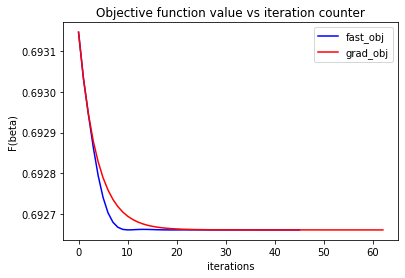

In [221]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fast_obj, c = 'b', label = 'fast_obj')
ax.plot(grad_obj, c = 'r', label = 'grad_obj')
ax.set_title('Objective function value vs iteration counter')
ax.set_xlabel('iterations')
ax.set_ylabel('F(beta)')
ax.legend()

The fast gradient algorithm converges quickly whereas the gradient descent algorithm converges much more slowly (~20 iterations)  

*question- is this suppose to compare fastalgo vs sklearn?*

From *scikit-learn* docs:  

As an optimization problem, binary class 
 penalized logistic regression minimizes the following cost function:
$\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$  
[source](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)  
$C = \frac{1}{2\lambda n}$

10. Denote by $\beta_T$ the final iterate of your fast gradient algorithm. Compare $\beta_T$ to the $\beta^*$ found by *scikit-learn*. Compare the objective value for $\beta_T$ to the one for $\beta^*$. What do you observe?

In [174]:
b_t = fast_b[-1]
obj_t = fast_obj[-1]

print('b_t: ', b_t)
print('obj_t: ', obj_t)

b_t:  [-0.01484462 -0.01436989  0.01878818]
obj_t:  0.6926603440733013


In [186]:
n = Xs.shape[0]
c = 1/(2*lamb*n)
m = LogisticRegression(C = c).fit(Xs, y_train)
sk_beta = m.coef_
sk_obj = obj_function(Xs, y_train, sk_beta, lamb)

In [187]:
print('sk_beta', sk_beta)
print('sk_obj', sk_obj)

sk_beta [[-0.01484767 -0.01437086  0.01879114]]
sk_obj 0.6926603440759008


The two methods produce very close outputs

11. Run cross-validation on the training set of the smarket dataset using *scikit-learn* to find the opitmal value of $\lambda$ (see `sklearn.linear_model.LogisticRegressionCV`). Again, note that the scikit-learn's penalty $C$ is not the same as our $\lambda$. Find the value $\lambda^*$ corresponding to the best choice $C^*$ obtained with this method. Run *graddescent* and *fastgradalgo* to optimize the objective with $\lambda = \lambda^*$. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter $t$. Plot the misclassification error on the training set for both algorithms versus the iteration counter $t$. Plot the misclassification error on the test set for both algorithms versus the iteration counter $t$. What do you observe?

In [223]:
skC = LogisticRegressionCV().fit(Xs, y_train).C_[0]
lamb_star = skC / (2*n*skC)
print('lamb_star: ', lamb_star)

lamb_star:  0.0005


In [217]:
#fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb)
grad_b_star = graddescent(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb_star)
grad_obj_star = [obj_function(Xs, y_train, b, lamb_star) for b in grad_b_star]

fast_b_star = fastgradalgo(beta_init, eta_init, decay_rate, prop_constant, target_accuracy, lamb_star)
fast_obj_star = [obj_function(Xs, y_train, b, lamb_star) for b in fast_b_star]

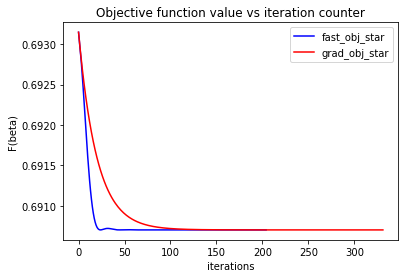

In [219]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fast_obj_star, c = 'b', label = 'fast_obj_star')
ax.plot(grad_obj_star, c = 'r', label = 'grad_obj_star')
ax.set_title('Objective function value vs iteration counter')
ax.set_xlabel('iterations')
ax.set_ylabel('F(beta)')
ax.legend()

In [222]:
b_star_t = fast_b_star[-1]
obj_star_t = fast_obj_star[-1]

print('b_t: ', b_star_t)
print('obj_t: ', obj_star_t)

b_t:  [-0.07678484 -0.07055442  0.09470311]
obj_t:  0.6907014337936142


In [306]:
x =100

y_x = np.exp(np.dot(Xs, grad_b_star[x]))/(1+np.exp(np.dot(Xs, grad_b_star[x])))

In [321]:
def get_y_pred(beta, X):
    
    """
    Return predicted y value given beta and X
    """
    
    pred = np.exp(np.dot(X, beta))/(1+np.exp(np.dot(X, beta)))
    y_pred = [1 if y > 0.5 else -1 for y in list(pred)]
    
    return np.array(y_pred)

def get_misclass(beta, X, y):
    
    """
    Return misclassification rate (1-correct) given true Y and predicted derived from beta and X
    """
    y_pred = get_y_pred(beta, X)
    
    return 1 - np.mean(y == y_pred)

In [319]:
misclass_

0.532

In [259]:
np.array([b for b in grad_b_star]).dot(Xs.T)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00431786, -0.00500513, -0.00253175, ...,  0.00032404,
        -0.00418528,  0.00341047],
       [-0.00852681, -0.00988434, -0.00499902, ...,  0.00063612,
        -0.0082651 ,  0.00673444],
       ...,
       [-0.17247206, -0.20048804, -0.10015276, ...,  0.00685971,
        -0.16740494,  0.13554414],
       [-0.1724732 , -0.2004894 , -0.10015338, ...,  0.00685946,
        -0.16740607,  0.13554503],
       [-0.17247432, -0.20049074, -0.10015399, ...,  0.00685922,
        -0.16740718,  0.13554589]])

In [232]:
y_train[5]

1